<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/EVA4_S2_mobilnet_v2_transfer_learning_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images.zip
!unzip -q final_images.zip
!rm -rf /content/__MACOSX
!find /content/final_images/data -name '.DS_Store' -type f -delete


In [3]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [5]:
# !rm -rf hymenoptera_data
# !wget -q "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
# !unzip -o -qq hymenoptera_data.zip
# !rm -rf hymenoptera_data.zip

In [6]:
from Modules import *

In [7]:
split_test_train_data('/content/final_images/data', tstRatio = 0.3)

['Large QuadCopters', 'Flying Birds', 'Small QuadCopters', 'Winged Drones']
4165
6761
3653
5673


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
#  = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= 192, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= 192,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Large QuadCopters', 'Flying Birds', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

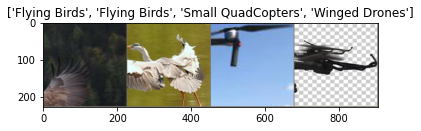

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


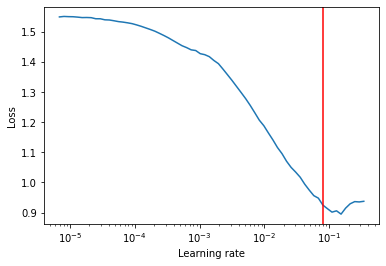

In [10]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.08) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [12]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.08, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          pct_start=0.20, 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [13]:
model_res = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 4.0487 Acc: 0.6576
val Loss: 1.7136 Acc: 0.7634

Epoch 1/24
----------
train Loss: 1.7396 Acc: 0.7310
val Loss: 1.2719 Acc: 0.7823

Epoch 2/24
----------
train Loss: 1.3813 Acc: 0.7338
val Loss: 1.0375 Acc: 0.7690

Epoch 3/24
----------
train Loss: 1.4175 Acc: 0.7305
val Loss: 0.8796 Acc: 0.7873

Epoch 4/24
----------
train Loss: 1.4709 Acc: 0.7249
val Loss: 1.2747 Acc: 0.7785

Epoch 5/24
----------
train Loss: 1.3212 Acc: 0.7362
val Loss: 1.0373 Acc: 0.7899

Epoch 6/24
----------
train Loss: 1.2499 Acc: 0.7334
val Loss: 0.9299 Acc: 0.7705

Epoch 7/24
----------
train Loss: 1.4362 Acc: 0.7268
val Loss: 1.1587 Acc: 0.7831

Epoch 8/24
----------
train Loss: 1.3774 Acc: 0.7309
val Loss: 0.9856 Acc: 0.7966

Epoch 9/24
----------
train Loss: 1.2951 Acc: 0.7314
val Loss: 0.9943 Acc: 0.7886

Epoch 10/24
----------
train Loss: 1.3068 Acc: 0.7244
val Loss: 0.9374 Acc: 0.8187

Epoch 11/24
----------
train Loss: 1.4062 Acc: 0.7360
val Loss: 0.9166 Acc: 0.7975

Epoch 12/24
----------
t

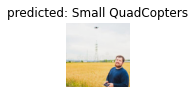

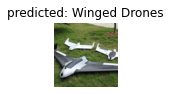

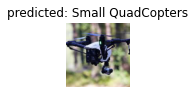

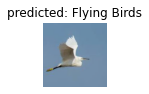

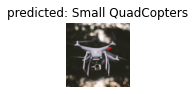

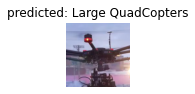

In [14]:
visualize_model(model_res, dataloaders, class_names, device)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


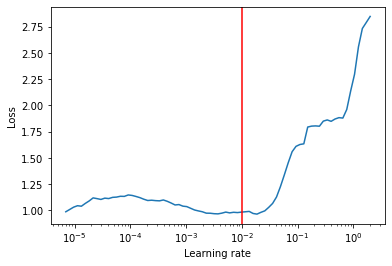

In [16]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [17]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          pct_start=0.20, 
                                          epochs=25)

In [18]:
model_final = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8693 Acc: 0.7596
val Loss: 0.5675 Acc: 0.8202

Epoch 1/24
----------
train Loss: 0.6175 Acc: 0.7736
val Loss: 0.4365 Acc: 0.8385

Epoch 2/24
----------
train Loss: 0.5011 Acc: 0.8070
val Loss: 0.3903 Acc: 0.8543

Epoch 3/24
----------
train Loss: 0.4491 Acc: 0.8225
val Loss: 0.3589 Acc: 0.8650

Epoch 4/24
----------
train Loss: 0.4073 Acc: 0.8380
val Loss: 0.3297 Acc: 0.8726

Epoch 5/24
----------
train Loss: 0.3831 Acc: 0.8507
val Loss: 0.3265 Acc: 0.8753

Epoch 6/24
----------
train Loss: 0.3614 Acc: 0.8573
val Loss: 0.3101 Acc: 0.8826

Epoch 7/24
----------
train Loss: 0.3388 Acc: 0.8687
val Loss: 0.3567 Acc: 0.8722

Epoch 8/24
----------
train Loss: 0.3422 Acc: 0.8656
val Loss: 0.3065 Acc: 0.8818

Epoch 9/24
----------
train Loss: 0.3246 Acc: 0.8740
val Loss: 0.3126 Acc: 0.8885

Epoch 10/24
----------
train Loss: 0.3141 Acc: 0.8785
val Loss: 0.2978 Acc: 0.8902

Epoch 11/24
----------
train Loss: 0.2993 Acc: 0.8841
val Loss: 0.3059 Acc: 0.8933

Ep

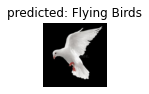

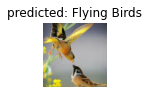

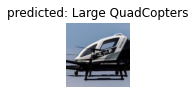

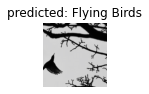

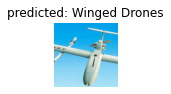

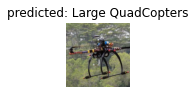

In [19]:
visualize_model(model_final, dataloaders, class_names, device)

plt.ioff()
plt.show()

# 9. Saving model

In [20]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v4.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v4.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v4.pt')